In [123]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

%matplotlib inline

In [124]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#Setup confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """This function prints and plots the confusion matrix.                                                                                                                     Normalization can be applied by setting `normalize=True`.                                                                                                                  """

    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = 2*cm.max() / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]), horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Load the data


In [125]:
data_file = 'Data/Raw_Data/Data_Cortex_Nuclear.xls'
data_file_path = os.path.join(os.getcwd(), data_file)
raw_data = pd.read_excel(data_file_path, header=0)
data_size = raw_data.shape

names= list(raw_data.columns.values)[1:-4]
prot_names=[x.encode('UTF8')[:-2] for x in names]
classes=list(set(raw_data['class']))

### Exploratory Data Analysis (EDA)

#### Data Summary

In [126]:
print("Data Summary:")
print(raw_data.head())

Data Summary:
  MouseID  DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N  \
0   309_1  0.503644  0.747193  0.430175  2.816329  5.990152  0.218830   
1   309_2  0.514617  0.689064  0.411770  2.789514  5.685038  0.211636   
2   309_3  0.509183  0.730247  0.418309  2.687201  5.622059  0.209011   
3   309_4  0.442107  0.617076  0.358626  2.466947  4.979503  0.222886   
4   309_5  0.434940  0.617430  0.358802  2.365785  4.718679  0.213106   

    pBRAF_N  pCAMKII_N   pCREB_N  ...   pCFOS_N     SYP_N  H3AcK18_N  \
0  0.177565   2.373744  0.232224  ...  0.108336  0.427099   0.114783   
1  0.172817   2.292150  0.226972  ...  0.104315  0.441581   0.111974   
2  0.175722   2.283337  0.230247  ...  0.106219  0.435777   0.111883   
3  0.176463   2.152301  0.207004  ...  0.111262  0.391691   0.130405   
4  0.173627   2.134014  0.192158  ...  0.110694  0.434154   0.118481   

     EGR1_N  H3MeK4_N    CaNA_N  Genotype  Treatment  Behavior   class  
0  0.131790  0.128186  1.675652   Control

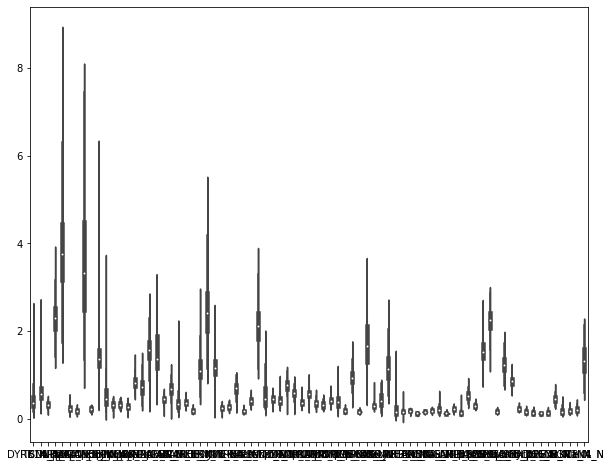

In [127]:

plt.figure(figsize=(10, 8))
sns.violinplot(data=raw_data)

plt.show()

In [128]:
# Data Information
print("\nData Information:")
print(raw_data.info())



Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MouseID          1080 non-null   object 
 1   DYRK1A_N         1077 non-null   float64
 2   ITSN1_N          1077 non-null   float64
 3   BDNF_N           1077 non-null   float64
 4   NR1_N            1077 non-null   float64
 5   NR2A_N           1077 non-null   float64
 6   pAKT_N           1077 non-null   float64
 7   pBRAF_N          1077 non-null   float64
 8   pCAMKII_N        1077 non-null   float64
 9   pCREB_N          1077 non-null   float64
 10  pELK_N           1077 non-null   float64
 11  pERK_N           1077 non-null   float64
 12  pJNK_N           1077 non-null   float64
 13  PKCA_N           1077 non-null   float64
 14  pMEK_N           1077 non-null   float64
 15  pNR1_N           1077 non-null   float64
 16  pNR2A_N          1077 non-null   float64


In [129]:
# Descriptive Statistics
print("\nDescriptive Statistics:")
print(raw_data.describe())


Descriptive Statistics:
          DYRK1A_N      ITSN1_N       BDNF_N        NR1_N       NR2A_N  \
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000   
mean      0.425810     0.617102     0.319088     2.297269     3.843934   
std       0.249362     0.251640     0.049383     0.347293     0.933100   
min       0.145327     0.245359     0.115181     1.330831     1.737540   
25%       0.288121     0.473361     0.287444     2.057411     3.155678   
50%       0.366378     0.565782     0.316564     2.296546     3.760855   
75%       0.487711     0.698032     0.348197     2.528481     4.440011   
max       2.516367     2.602662     0.497160     3.757641     8.482553   

            pAKT_N      pBRAF_N    pCAMKII_N      pCREB_N       pELK_N  ...  \
count  1077.000000  1077.000000  1077.000000  1077.000000  1077.000000  ...   
mean      0.233168     0.181846     3.537109     0.212574     1.428682  ...   
std       0.041634     0.027042     1.295169     0.032587     0.466904 

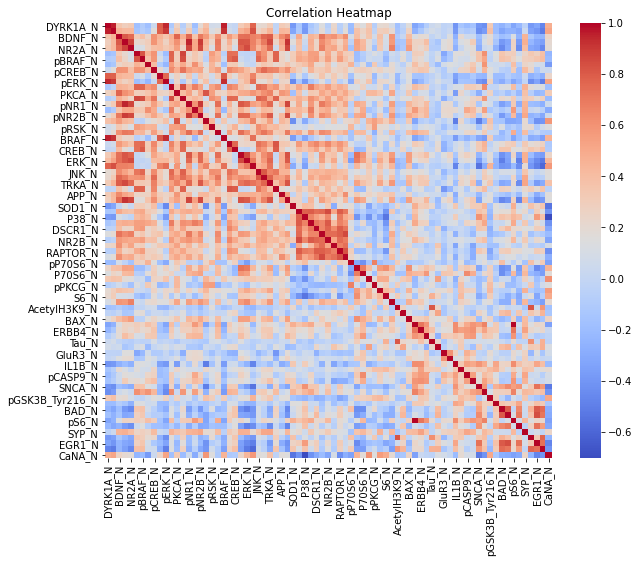

In [130]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(raw_data.corr(),  cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('visualizations/corr_no_feature_selection.png',bbox_inches='tight')
plt.show()

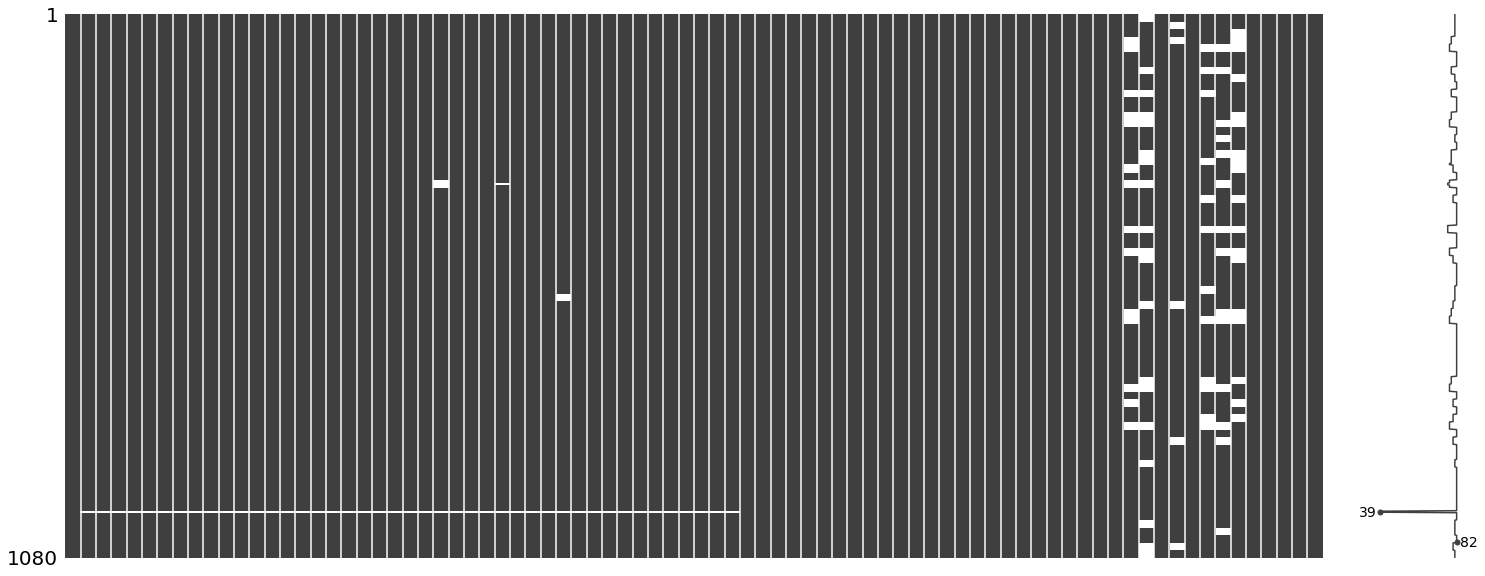

In [131]:
import missingno as msno
# fig, ax = plt.subplots()
msno.matrix(raw_data)
# ax.set_xticklabels(np.repeat(prot_names, 2),
                    # rotation=45, fontsize=8)

plt.savefig('visualizations/missing_matrix.png')
plt.show()

### Data Preprocessing

####  Handling Missing Values 
There are few samples that more than half of their protein level expressions are missed. For three replicates of a measurement, the majority of protein levels  have 43 missing values, and the available values are also quite different from those for other samples. Thus these samples are excluded from the dataset. 

In [132]:
print('number of missing values',raw_data.isnull().sum().sum())

# Excluding the samples which had missing values for the majority of proteins                                                             
df=raw_data[raw_data.isnull().sum(axis=1)<40]
df_size=df.shape
print(data_size[0]-df_size[0], 'of samples had more than 40 missing values. These instances were excluded')

print('number of missing values',df.isnull().sum().sum())


number of missing values 1396
3 of samples had more than 40 missing values. These instances were excluded
number of missing values 1267


Imputation employed for completing other missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

In [133]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
data_complete = raw_data.copy()
data_complete.iloc[:,1:78]= imputer.fit_transform(X)

In [134]:
X_complete = data_complete.iloc[:,1:78]
feature_names = X_complete.columns
y = data_complete['class']

In [135]:
data_file_new = 'Data/Processed_Data/processed_data.xlsx'
data_file_new_path = os.path.join(os.getcwd(), data_file)
data_complete.to_excel(data_file_new, engine='xlsxwriter')

### Identifying Key proteins discriminate between 8 different control and trisomy mice using feature selection methods

#### Data splititing and Scaling

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_file = 'Data/Processed_Data/processed_data.xlsx'
data_file_path = os.path.join(os.getcwd(), data_file)
data = pd.read_excel(data_file_path, header=0)
data_size = data.shape

names= list(raw_data.columns.values)[1:-4]
prot_names=[x.encode('UTF8')[:-2] for x in names]
classes=list(set(raw_data['class']))


# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_complete, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Building classifier

In [137]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier()

#### Grid search over random forest parameters

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(classifier, param_grid=param_grid)

start = time.time()
grid_search.fit(X_train_scaled, y_train)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)
classifier= grid_search.best_estimator_


GridSearchCV took 99.02 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.983 (std: 0.011)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.981 (std: 0.011)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.979 (std: 0.010)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3}



#### Evaluation of the classifier without feature selection

After cross validation, Scores are:  [ 96.55  98.85  96.55  98.85  98.84  97.67  97.67 100.    98.84  98.84]
Mean:  0.9826650628174285  and Standard Deviation:  0.010604937239084915
              precision    recall  f1-score   support

      c-SC-s       1.00      1.00      1.00        32
      t-CS-s       1.00      1.00      1.00        26
      c-CS-s       1.00      0.96      0.98        27
      t-SC-s       0.97      1.00      0.99        34
      t-SC-m       1.00      1.00      1.00        19
      t-CS-m       1.00      1.00      1.00        22
      c-SC-m       1.00      1.00      1.00        25
      c-CS-m       1.00      1.00      1.00        31

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.96 0.04 0.   0.   0.   0.  ]
 [0.   0. 

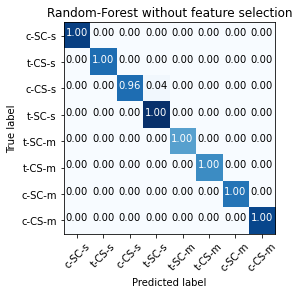

In [139]:
fitted=classifier.fit(X_train_scaled,y_train)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_train_scaled,y_train, cv = 10)
print('After cross validation, Scores are: ', scores * 100)
print('Mean: ', scores.mean(), ' and Standard Deviation: ', scores.std())

from sklearn.metrics import classification_report
predicted = fitted.predict(X_test_scaled)
print(classification_report(y_test, predicted, target_names=classes))


conf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision = 2)
plt.figure('Figure 1')
plot_confusion_matrix(conf_matrix,
                      classes = classes,
                      title = 'Random-Forest without feature selection',
                      normalize = True)
plt.savefig('visualizations/visualizations/cm_No_feature_selection.png',bbox_inches='tight')

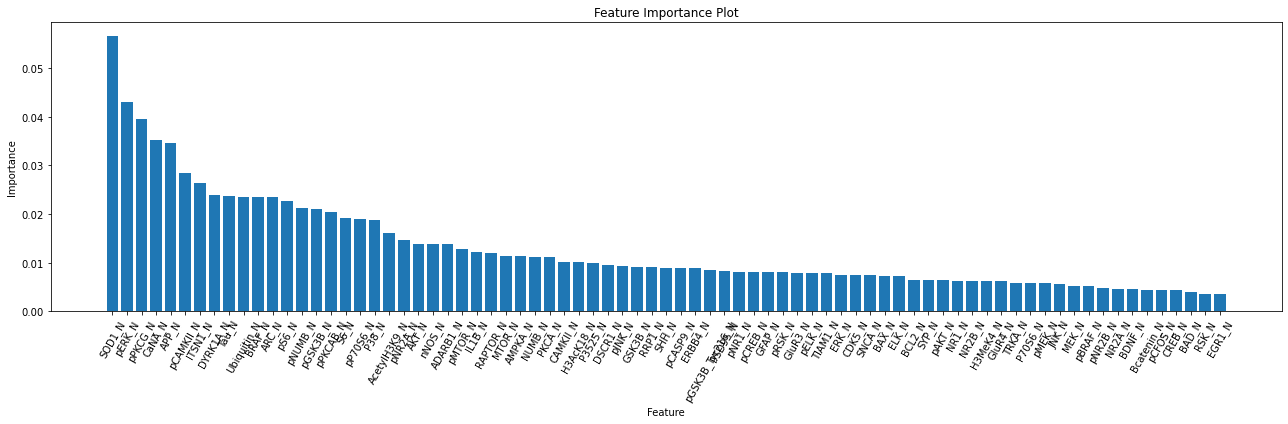

In [140]:
import pandas as pd

importances = classifier.feature_importances_
importances = pd.Series(importances, index=feature_names)

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plotting the feature importance
plt.figure(figsize=(18, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=60)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.savefig('visualizations/imp_all_bar.png')
plt.tight_layout()
plt.show()

#### Feature Selection using Recursive Feature Elimination (RFE)

In [141]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator = classifier, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy')

# Perform RFECV feature selection on the training data
rfecv.fit(X_train_scaled, y_train)

# Get the selected feature indices
selected_indices = rfecv.get_support(indices=True)

# Get the selected feature names
selected_feature_names_RF = [feature_names[i] for i in selected_indices]

# Print the selected feature names
print("Selected Features:")
print(selected_feature_names_RF)



Selected Features:
['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N', 'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N', 'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N', 'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N', 'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'SOD1_N', 'MTOR_N', 'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N', 'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N', 'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N', 'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N', 'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N', 'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BCL2_N', 'pS6_N', 'SYP_N', 'H3AcK18_N', 'H3MeK4_N', 'CaNA_N']


##### Transform the training and test data based on the selected features


In [142]:
X_train_selected = rfecv.transform(X_train_scaled)
X_test_selected = rfecv.transform(X_test_scaled)
print (X_test_scaled.shape)

print("Optimal number of features : %d" % rfecv.n_features_)
print('accuracy of the model based on selected features is ', rfecv.grid_scores_[rfecv.n_features_])

(216, 77)
Optimal number of features : 73
accuracy of the model based on selected features is  0.9884656508954827


#### Evaluation of the classifier with feature selection

After cross validation, Scores are:  [ 97.7  100.    97.7  100.   100.    98.84  97.67 100.    98.84 100.  ]
Mean:  0.9907511360598772  and Standard Deviation:  0.010063683595489072
              precision    recall  f1-score   support

      c-SC-s       1.00      1.00      1.00        32
      t-CS-s       1.00      1.00      1.00        26
      c-CS-s       1.00      1.00      1.00        27
      t-SC-s       1.00      1.00      1.00        34
      t-SC-m       1.00      1.00      1.00        19
      t-CS-m       1.00      1.00      1.00        22
      c-SC-m       1.00      1.00      1.00        25
      c-CS-m       1.00      1.00      1.00        31

    accuracy                           1.00       216
   macro avg       1.00      1.00      1.00       216
weighted avg       1.00      1.00      1.00       216

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0.

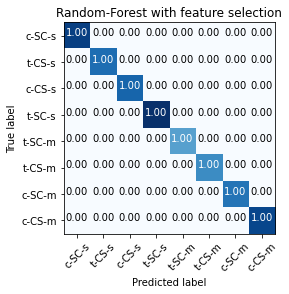

In [143]:
fitted=classifier.fit(X_train_selected,y_train)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(classifier, X_train_selected,y_train, cv = 10)
print('After cross validation, Scores are: ', scores * 100)
print('Mean: ', scores.mean(), ' and Standard Deviation: ', scores.std())

from sklearn.metrics import classification_report
predicted = fitted.predict(X_test_selected)
print(classification_report(y_test, predicted, target_names=classes))


conf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision = 2)
plt.figure('Figure 2')
plot_confusion_matrix(conf_matrix,
                      classes = classes,
                      title = 'Random-Forest with feature selection',
                      normalize = True)
plt.savefig('visualizations/cm_feature_selection.png',bbox_inches='tight')

##### Recursive Feature Elimination (RFE) Curve

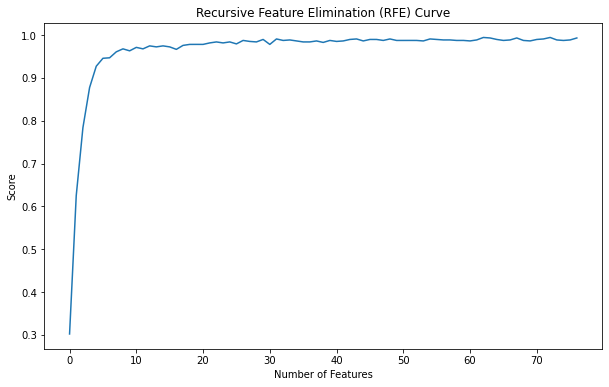

In [144]:
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination (RFE) Curve')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.savefig('visualizations/RFE Curve.png')
plt.plot(rfecv.grid_scores_)

##### Feature Importance Plot

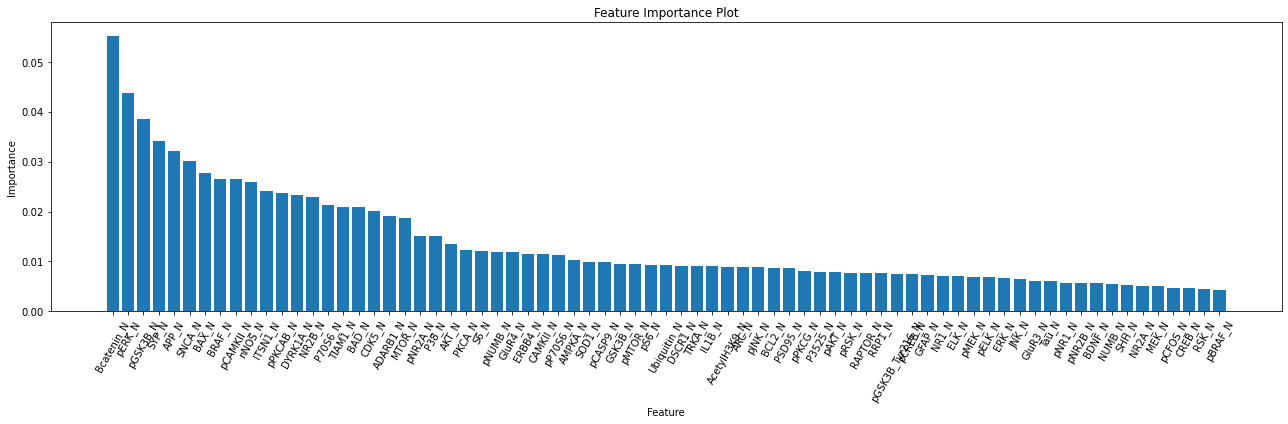

In [145]:
import pandas as pd

importances = classifier.feature_importances_
importances = pd.Series(importances, index=selected_feature_names_RF)

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plotting the feature importance
plt.figure(figsize=(18, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, align='center')
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=60)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.tight_layout()
plt.savefig('visualizations/imp_selected_bar.png')
plt.show()


#### Correlation Matrix Heatmap

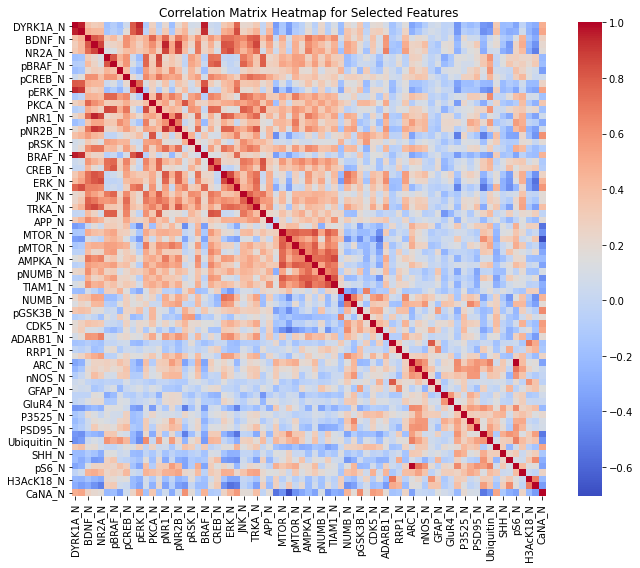

In [146]:
# Create a DataFrame with the selected features
df_selected = pd.DataFrame(X_train_scaled[:, selected_indices], columns=selected_feature_names_RF)

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as desired
sns.heatmap(corr_matrix, cmap='coolwarm',  square=True)
plt.title("Correlation Matrix Heatmap for Selected Features")
plt.tight_layout()
plt.savefig('visualizations/corr_selected.png')
plt.show()